In [1]:
# Data Processing
import numpy as np
import pandas as pd

# Basic Visualization tools
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_palette('husl')


# Bokeh (interactive visualization)
import bokeh
from bokeh.io import show, output_notebook
from bokeh.palettes import Spectral9
from bokeh.plotting import figure
output_notebook() # You can use output_file()

# Special Visualization
import missingno
import missingno as msno # check missing value
import networkx as nx

# Check file list
#import os
#print(os.listdir('../input/17k-apple-app-store-strategy-games'))

Loading BokehJS ...

In [2]:
data = pd.read_csv('appstore_games.csv')
data = data.drop(['URL', 'ID'], axis=1)

In [3]:
data['GenreList'] = data['Genres'].apply(lambda s : s.replace('Games','').replace('&',' ').replace(',', ' ').split()) 
data['GenreList'].head()

0              [Strategy, Puzzle]
1               [Strategy, Board]
2               [Board, Strategy]
3              [Strategy, Puzzle]
4    [Strategy, Board, Education]
Name: GenreList, dtype: object

In [4]:
gameTypes = []
for i in data['GenreList']: gameTypes += i
gameTypes = set(gameTypes)
print("There are {} types in the Game Dataset".format(len(set(gameTypes))))

There are 56 types in the Game Dataset


In [43]:
data.head()

,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,GenreList
0,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017,"[Strategy, Puzzle]"
1,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018,"[Strategy, Board]"
2,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017,"[Board, Strategy]"
3,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017,"[Strategy, Puzzle]"
4,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018,"[Strategy, Board, Education]"


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer # Similar to One-Hot Encoding

test = data['GenreList']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)

<ipython-input-32-9c053b85fa92>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


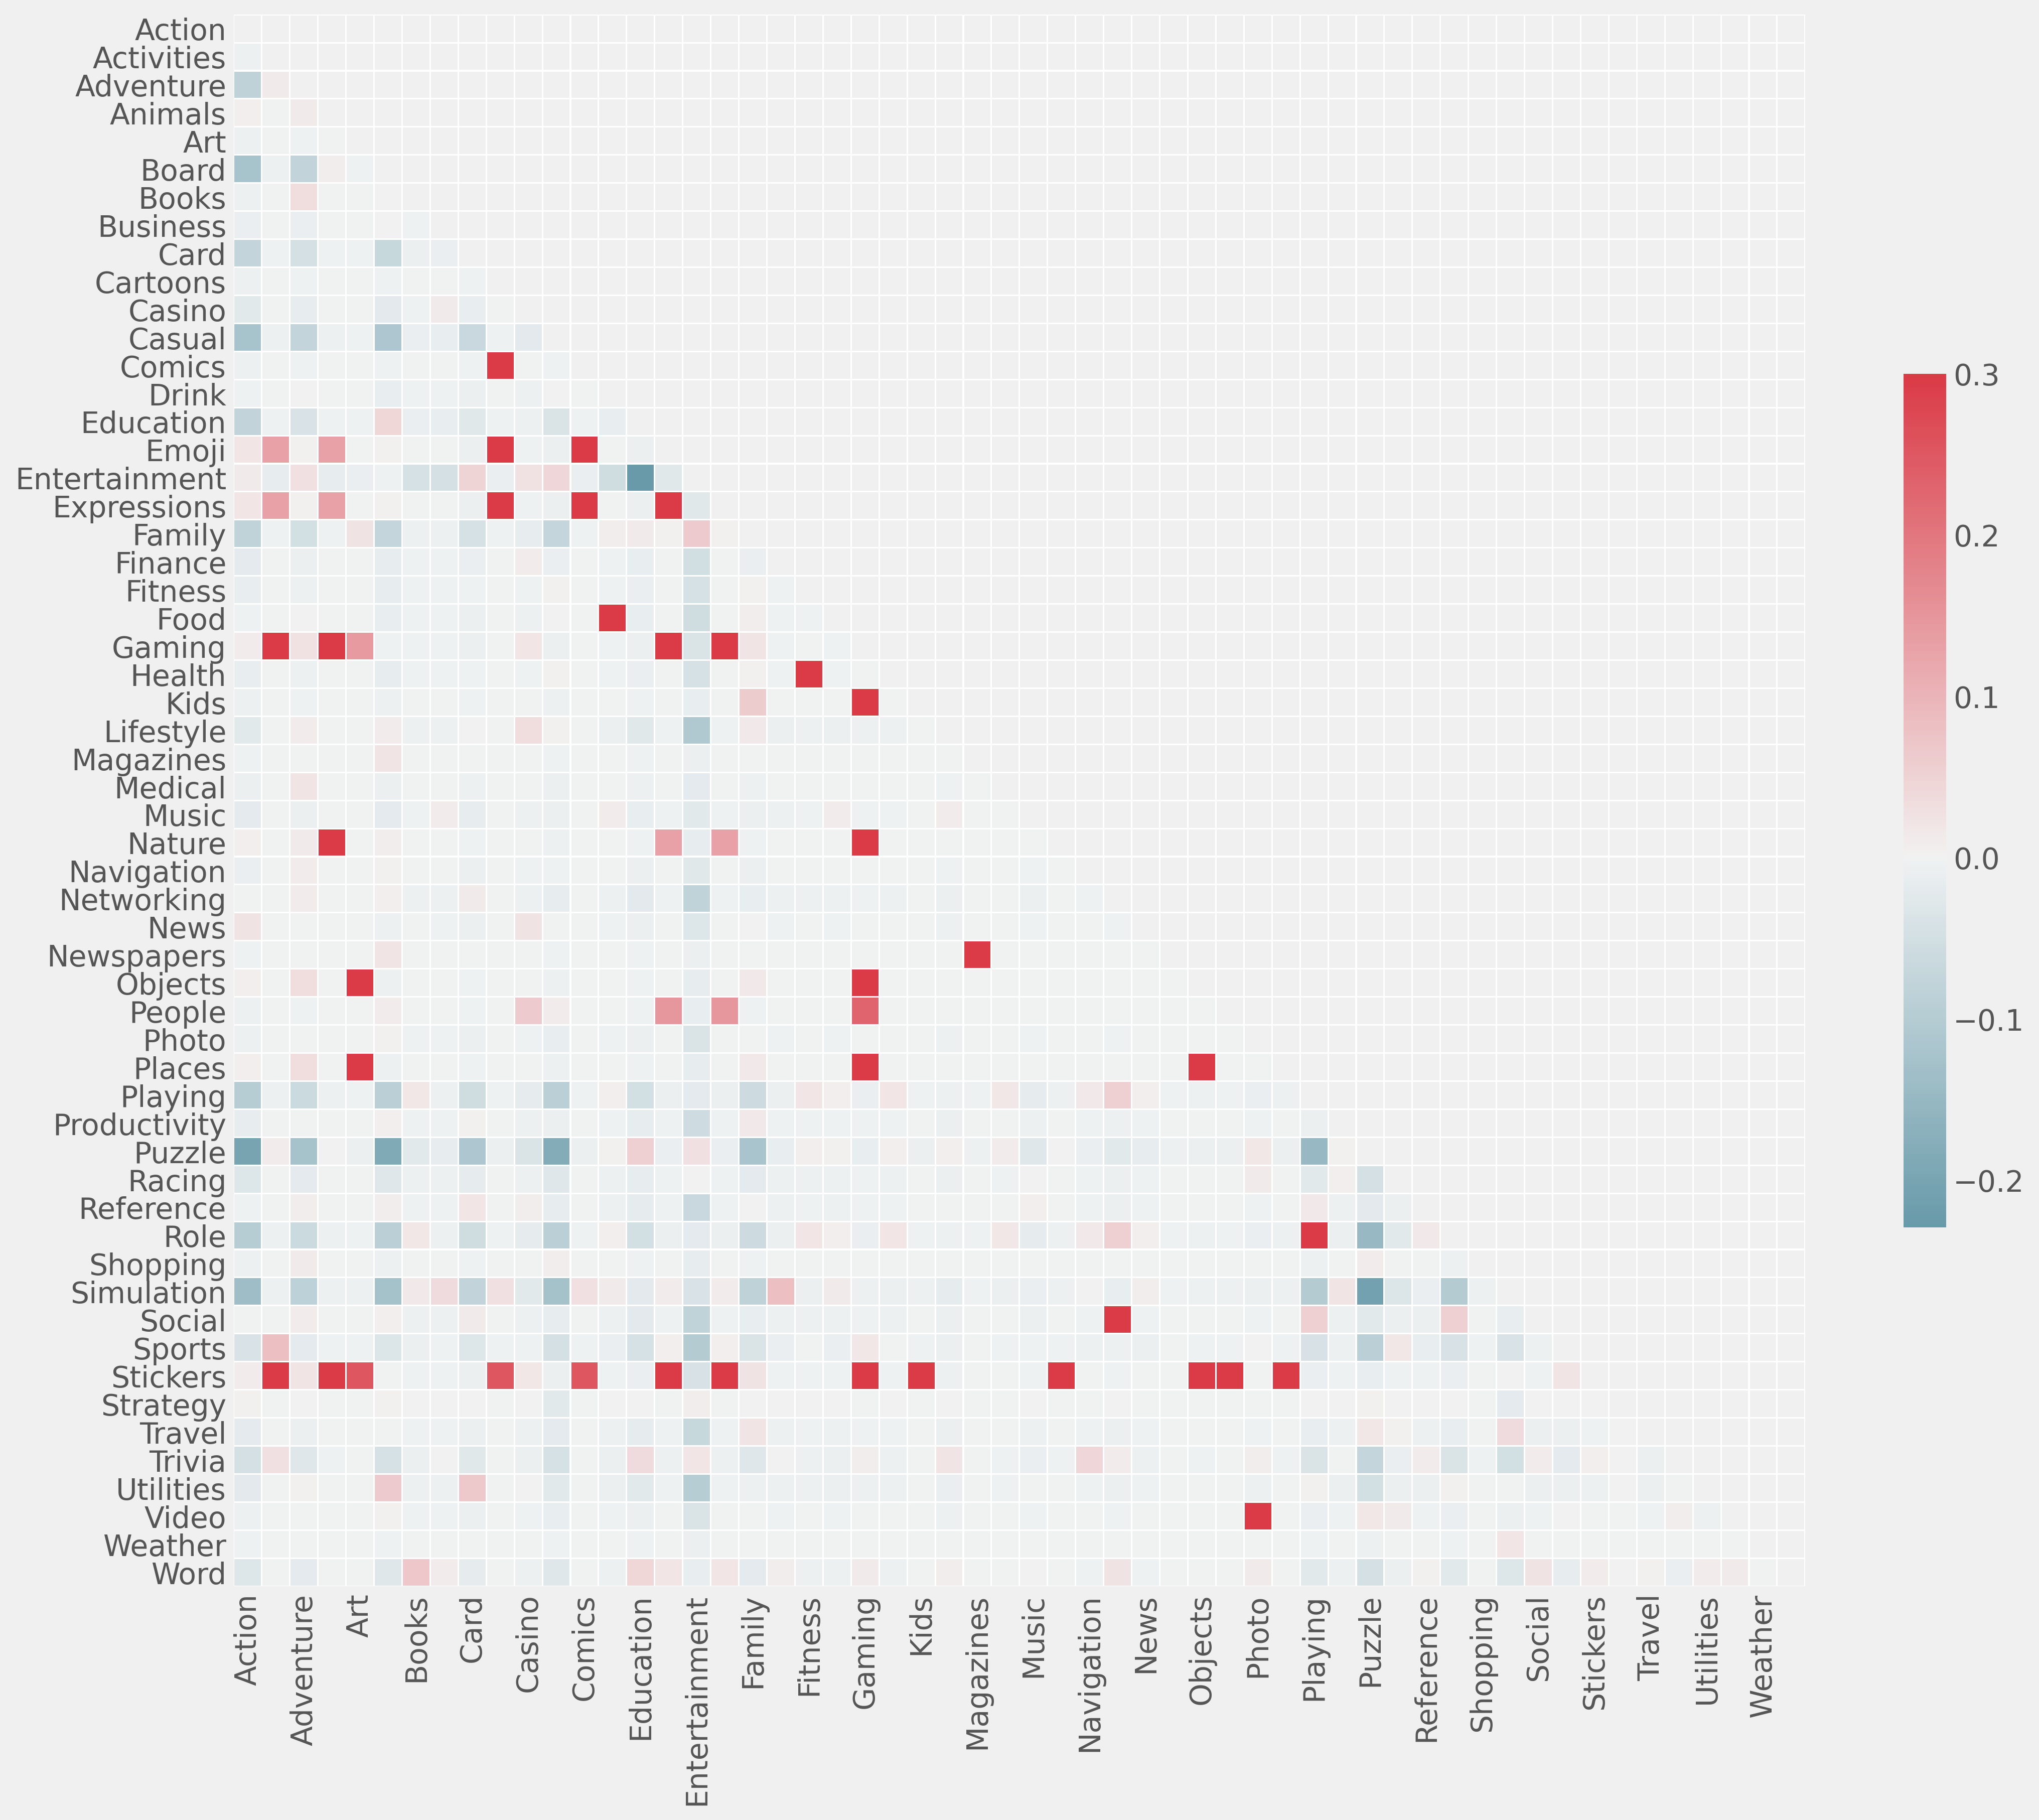

In [32]:
corr = res.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heatmap.png')

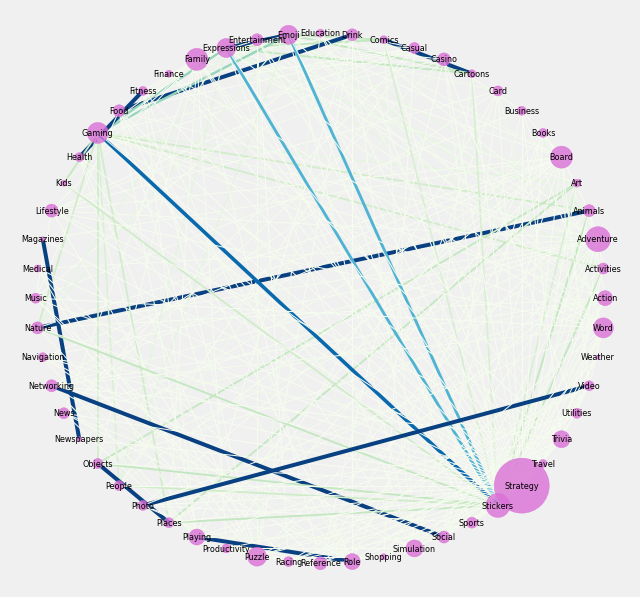

In [34]:
import networkx as nx

stocks = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

def create_corr_network(G, corr_direction, min_correlation):
    H = G.copy()
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)

    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.savefig('network.png')
    plt.show() 
    
    
#create_corr_network(G, 'positive', 0.3)
create_corr_network(G, 'positive', -0.3)

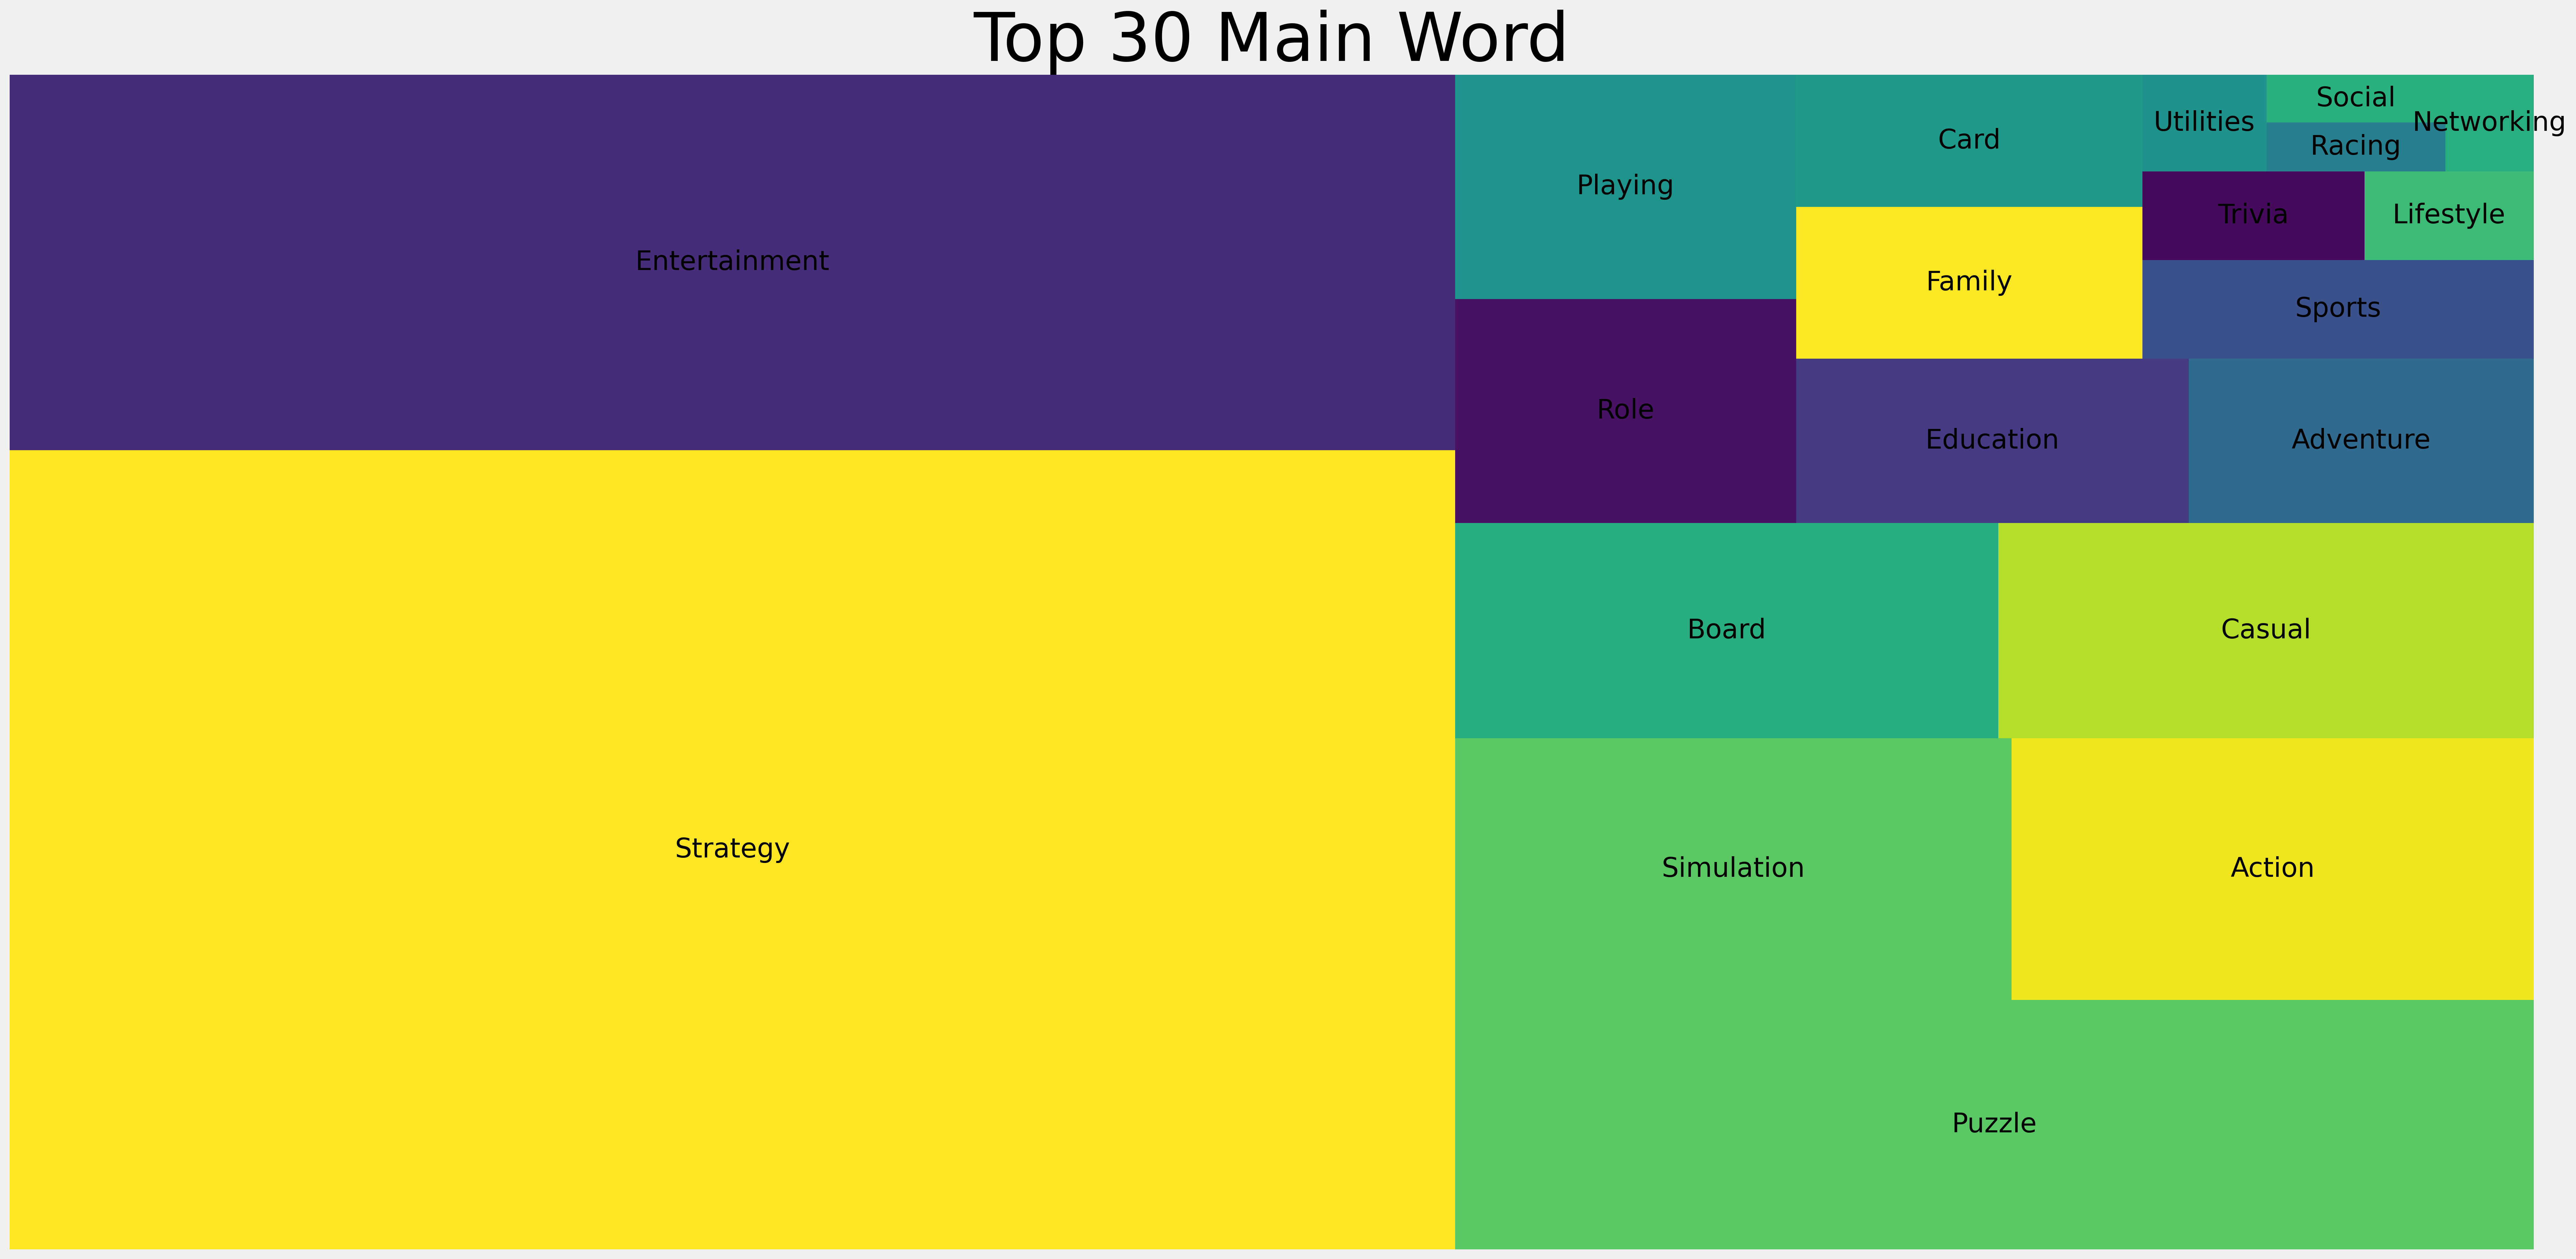

In [33]:
import squarify
y = res.apply(sum).sort_values(ascending=False)[:20]
    
plt.rcParams['figure.figsize'] = (30, 15)
plt.style.use('fivethirtyeight')

squarify.plot(sizes = y.values, label = y.index, text_kwargs={'fontsize':20})
plt.title('Top 30 Main Word', fontsize = 50)
plt.axis('off')
plt.savefig('treemap.png')
plt.show()

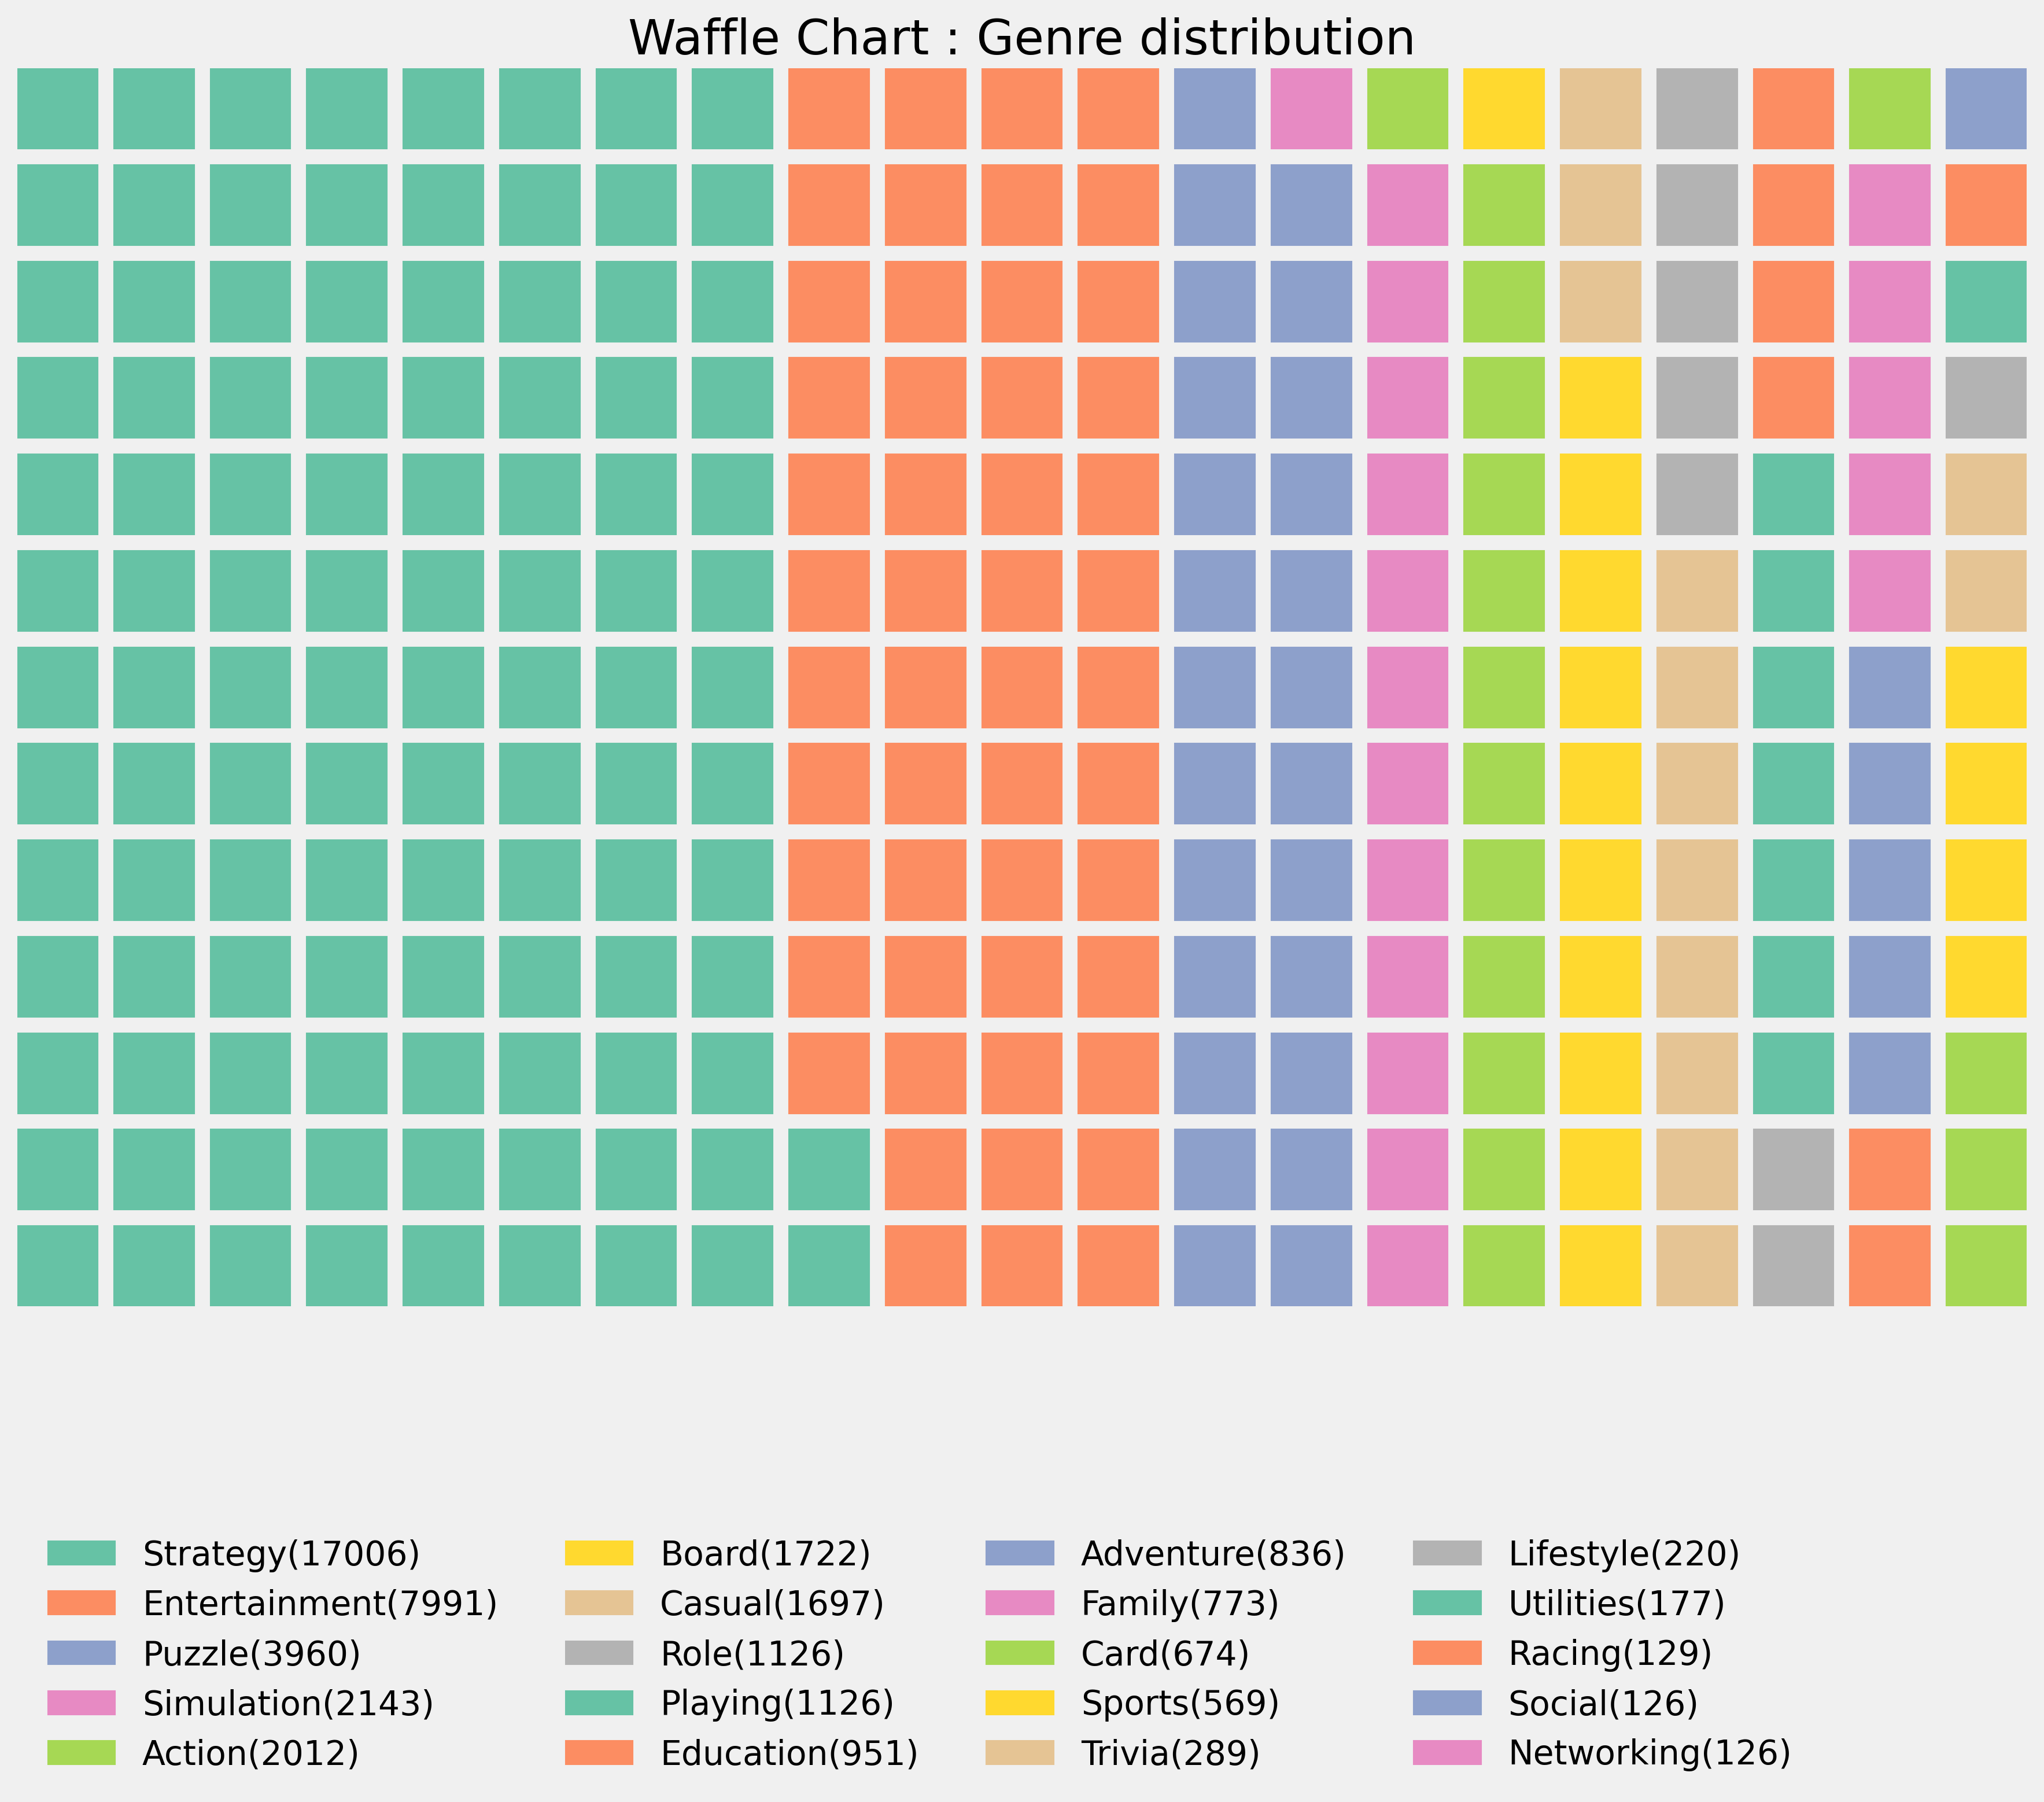

In [39]:
from pywaffle import Waffle
# type 2 : Auto-Size
fig = plt.figure(
    FigureClass=Waffle, 
    rows=13, 
    columns=21, 
    values=y,
    labels=["{}({})".format(a, b) for a, b in zip(y.index, y) ],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(y)//5,  'framealpha': 0},
    font_size=20, 
    figsize=(12, 12),  
    icon_legend=True
)

plt.title('Waffle Chart : Genre distribution')
plt.savefig('waffle.png')
plt.show()


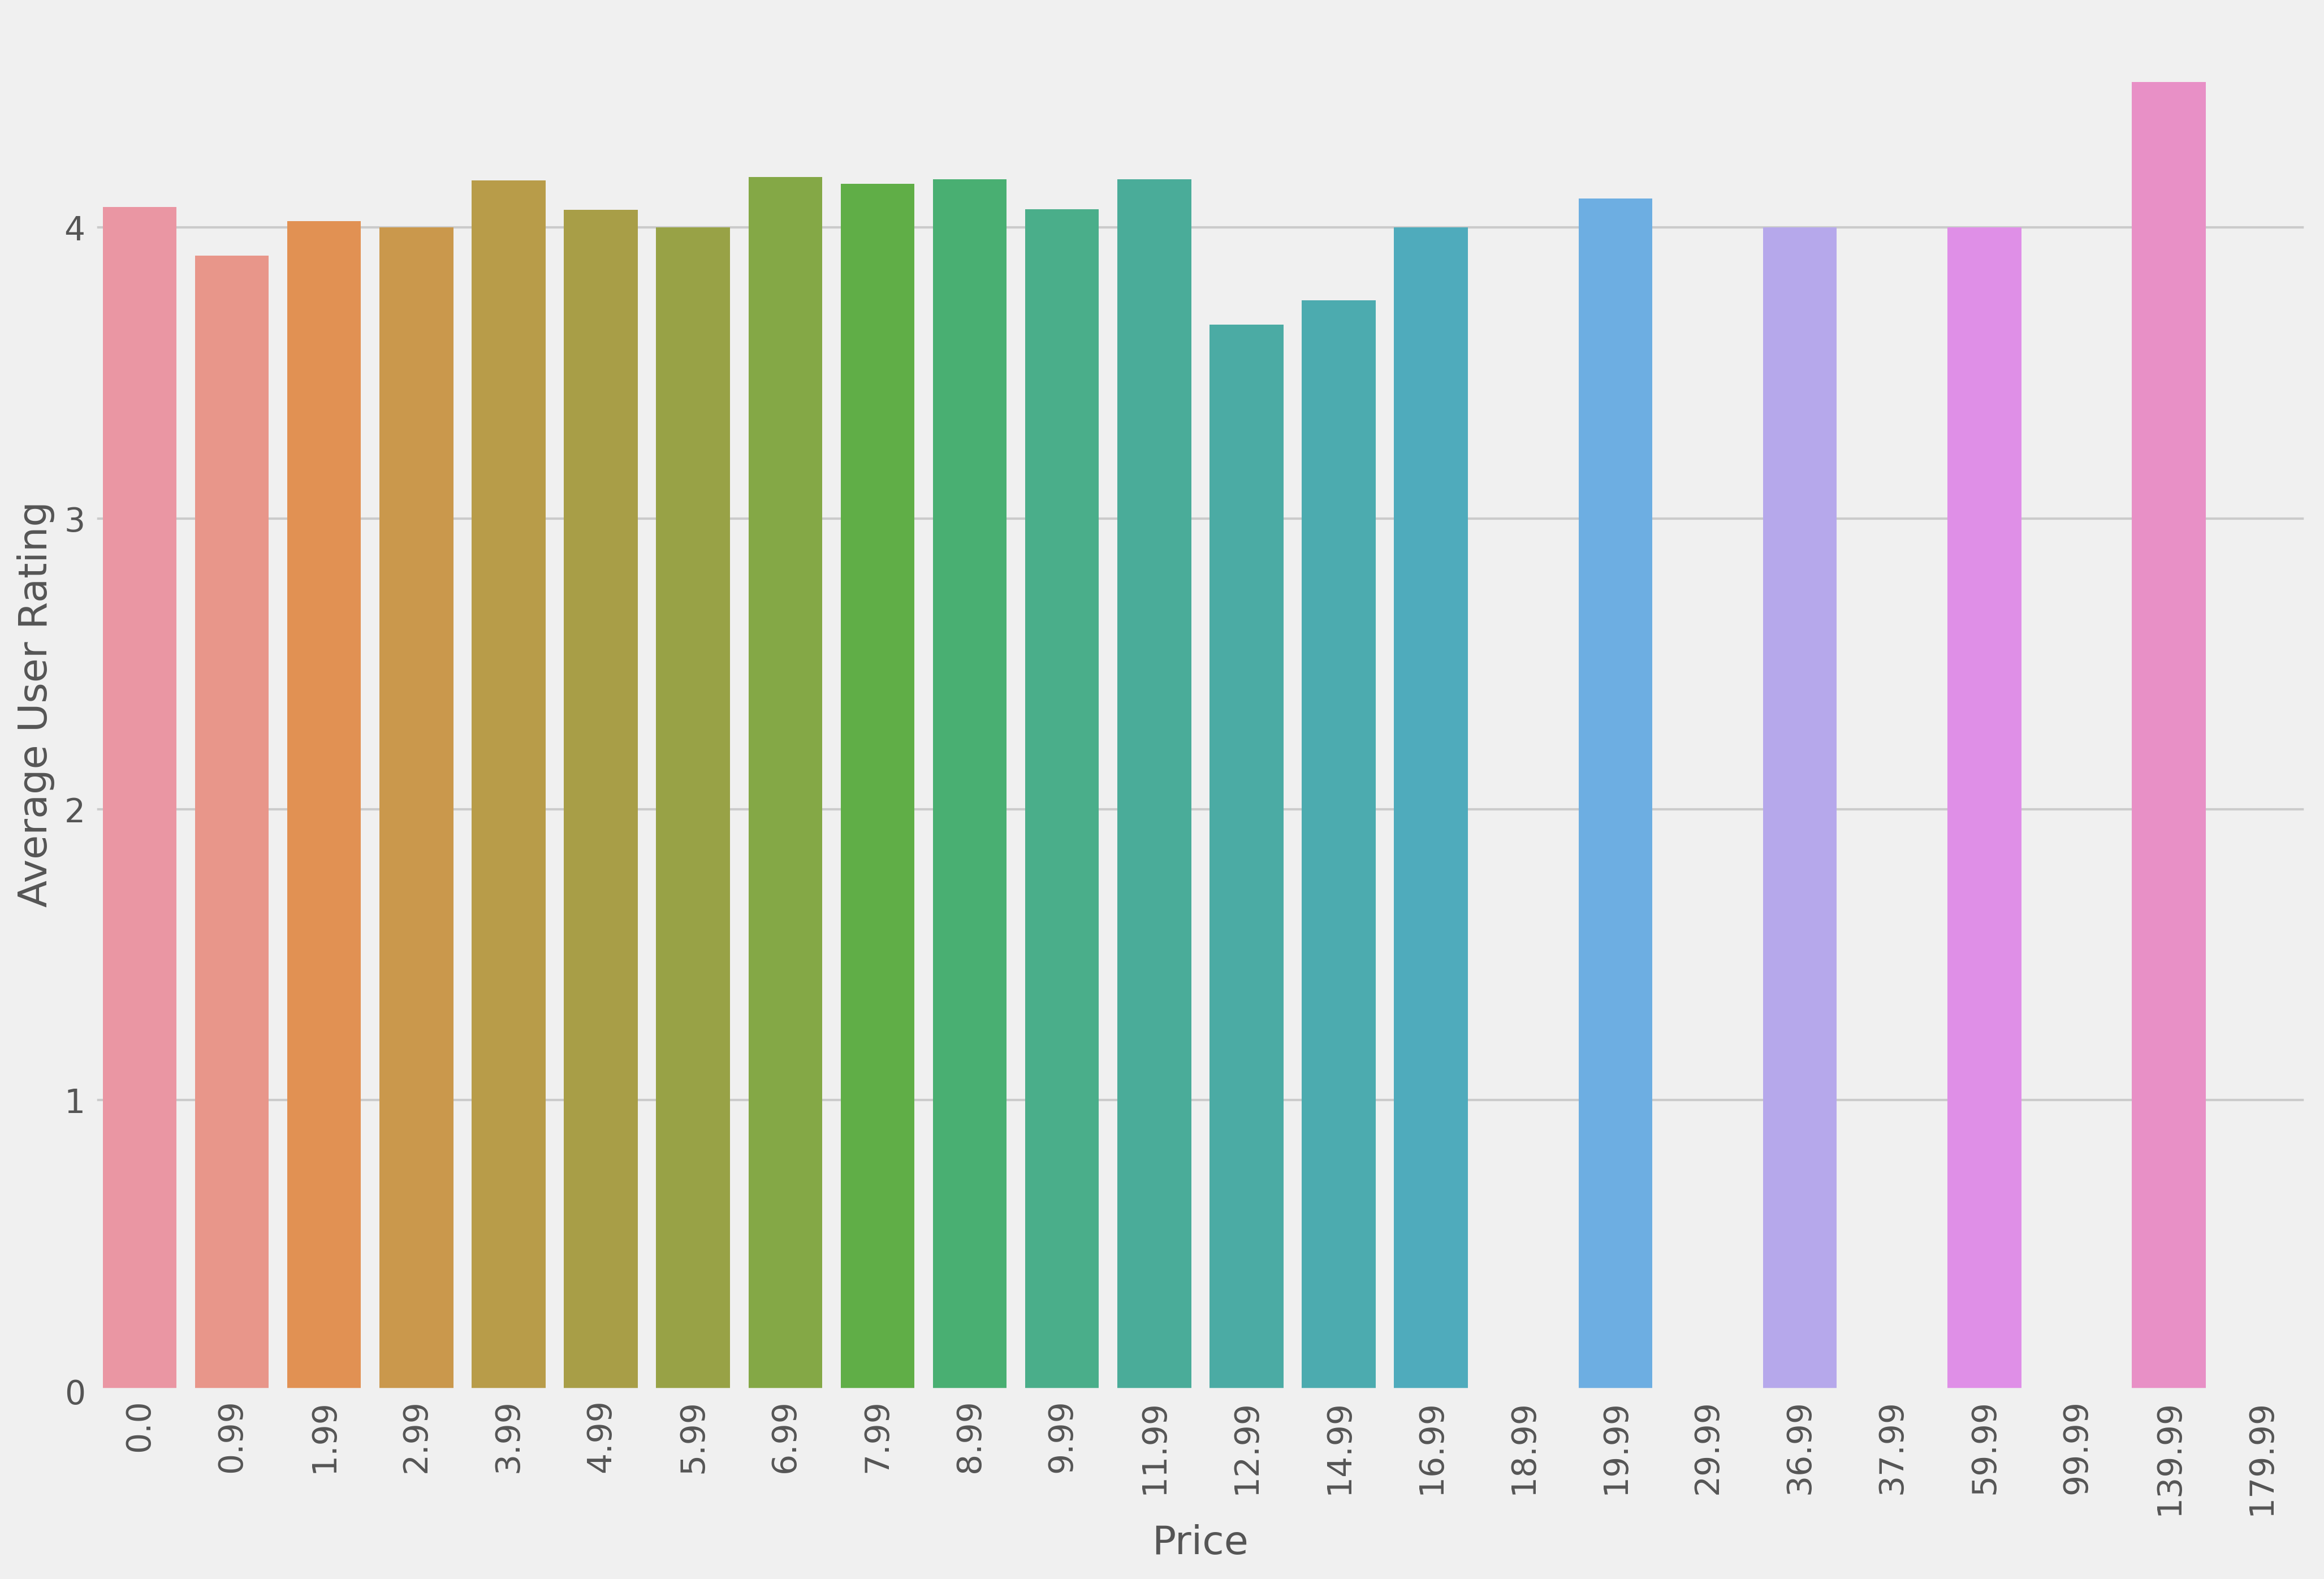

In [59]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Price', data=data, y = 'Average User Rating', ci = None)
plt.xticks(rotation=90)
plt.savefig('avgrating.png')
plt.show()

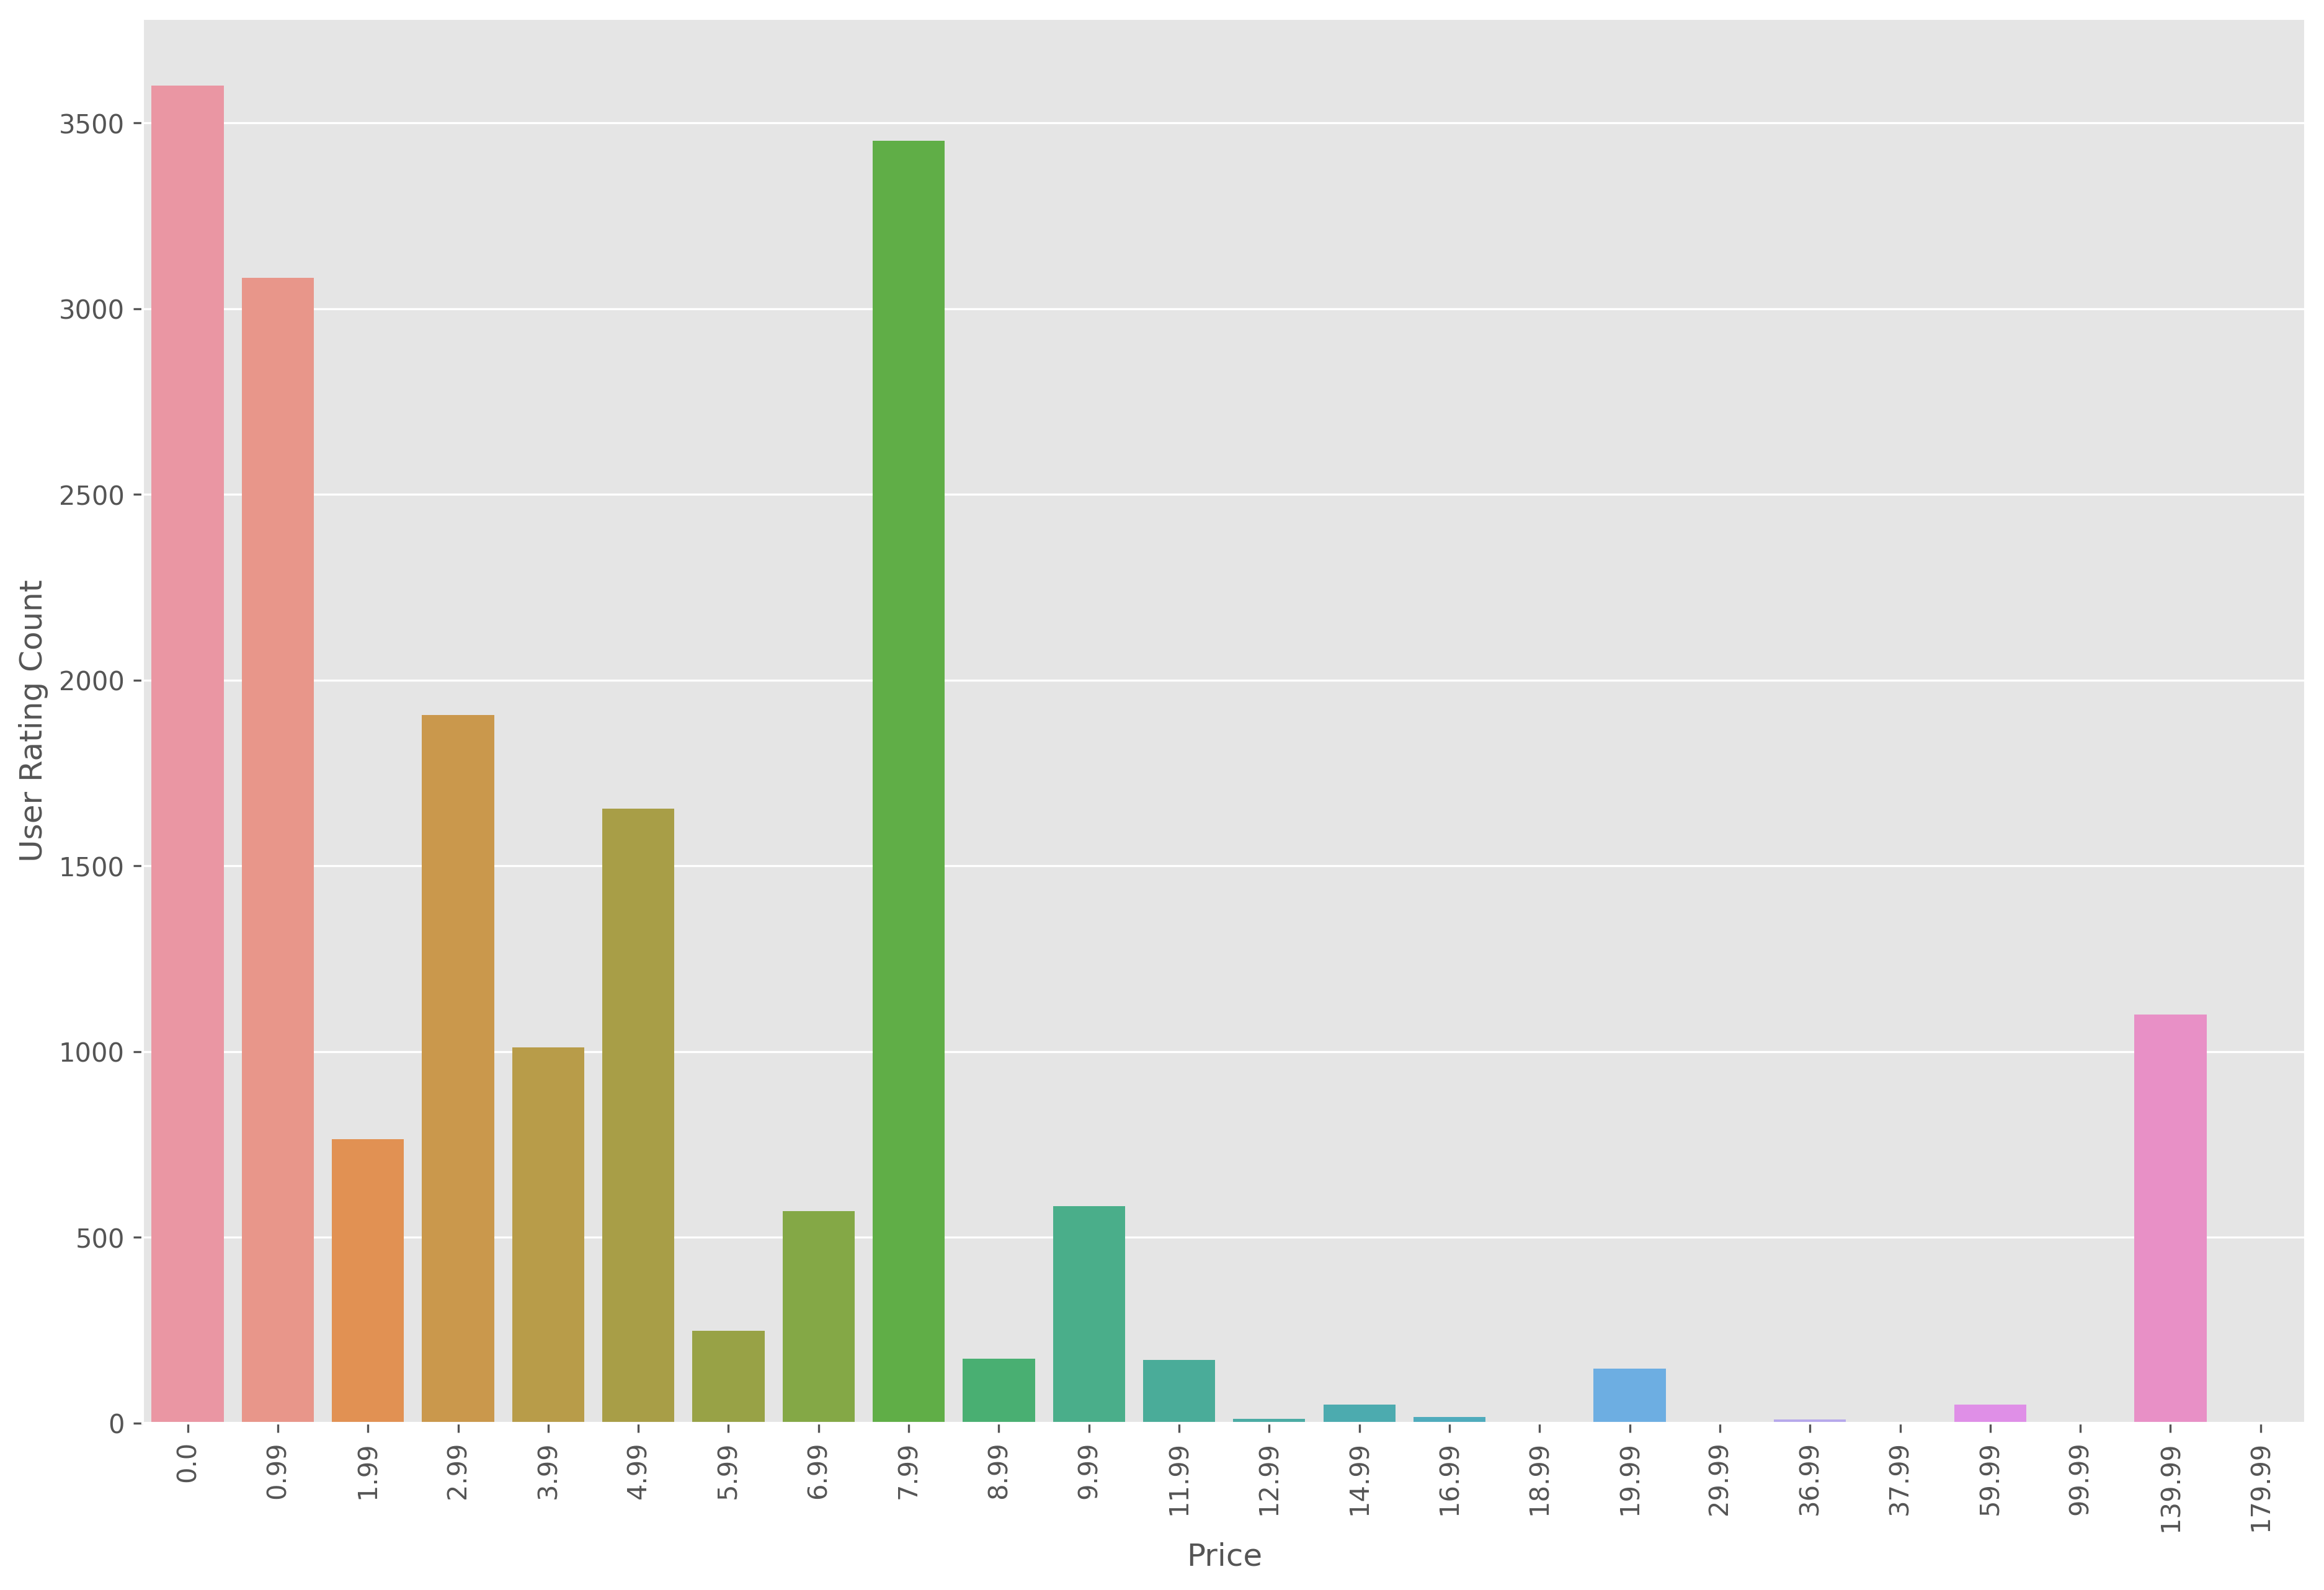

In [25]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Price', data=data, y = 'User Rating Count', ci = None)
plt.xticks(rotation=90)
plt.savefig('rating.png')
plt.show()

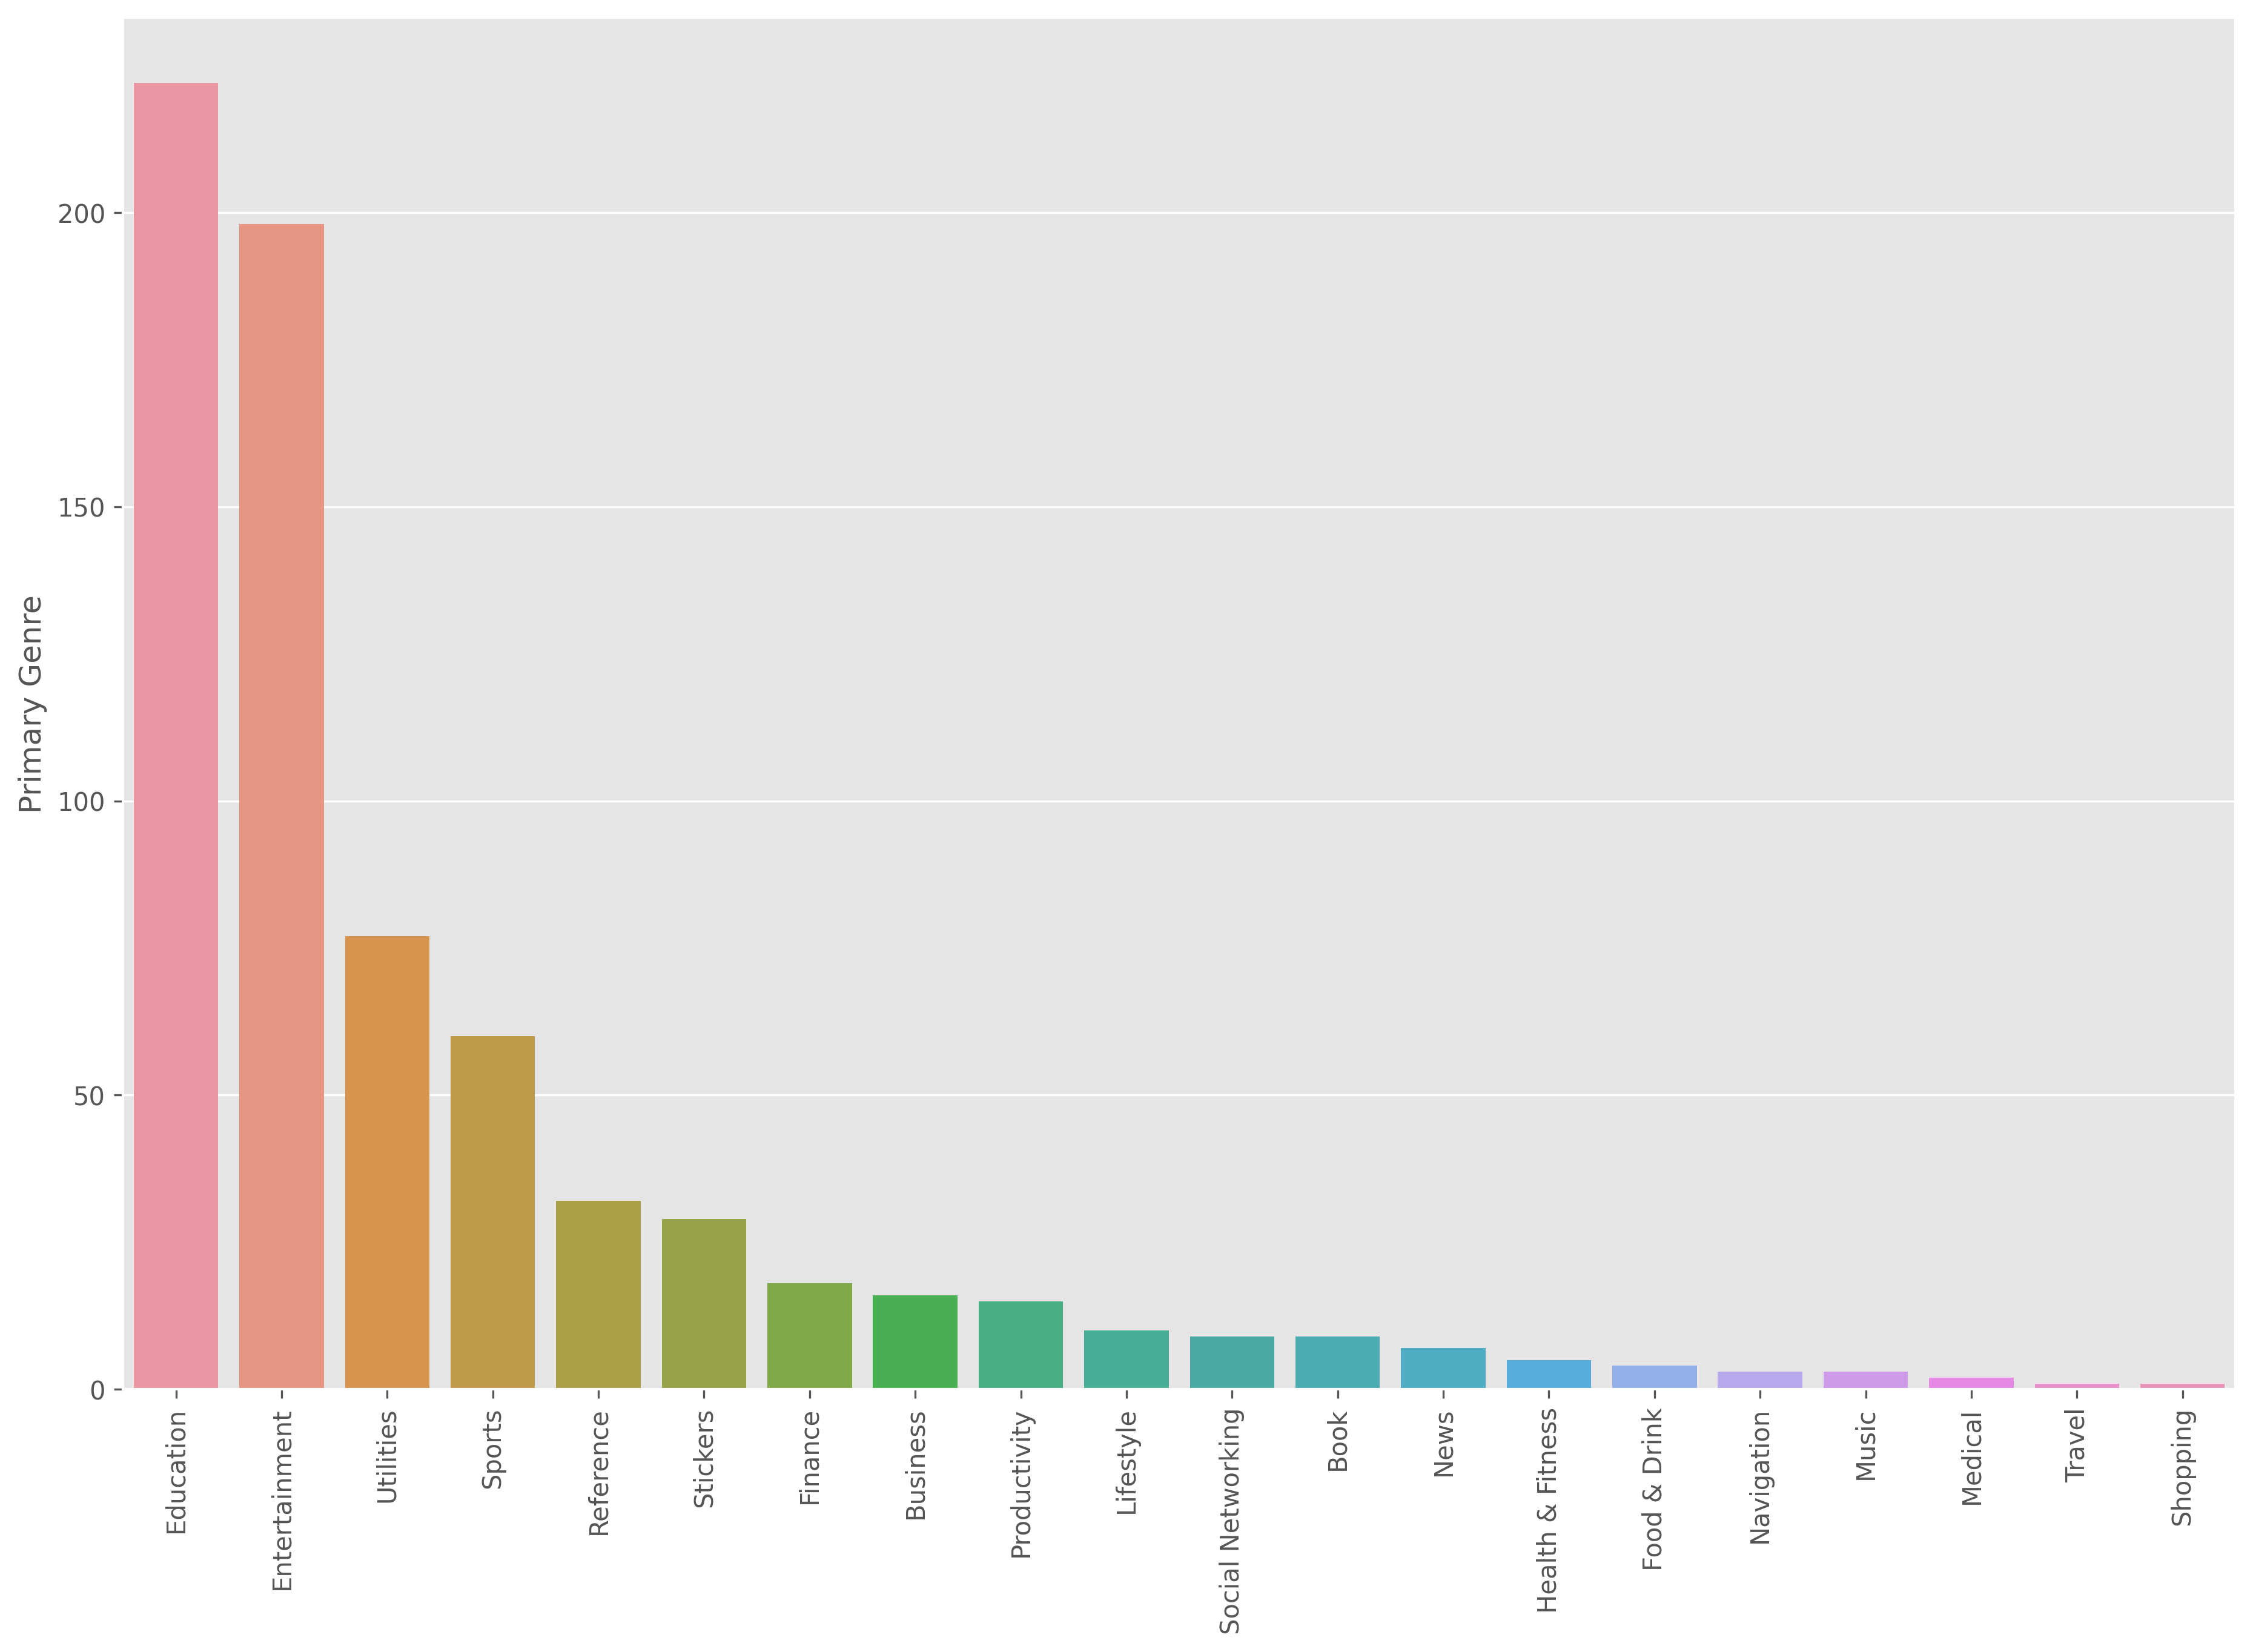

In [26]:
genre = data['Primary Genre'].value_counts()
genre = genre.drop('Games')
plt.figure(figsize=(15, 10))
sns.barplot(x=list(map(str, genre.index.values)), data=data, y = genre, ci = None)
plt.xticks(rotation=90)
plt.savefig('genre.png')
plt.show()